## KiSSim results only based on Erlotinib-interacting residues

> The advantage of IFPs is that they emphasize important residues and interactions as seen based on one or more ligands; the disadvantage is that not all possibly relevant interactions have been seen, yet.

How about KiSSim? Does it outperform the IFP approach still if we focus on residues that are covered by IFPs for a single residue.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging
import warnings

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
from opencadd.databases.klifs import setup_remote
from kissim.api import subset
from kissim.encoding import FingerprintGenerator

from src.data.interacting_residues import residues_interacting_with_ligand
from src.paths import PATH_RESULTS
from src import evaluation

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
PATH_RESULTS_DFG_IN = PATH_RESULTS / "dfg_in"

In [5]:
# Disable some unneeded warnings
logger = logging.getLogger("src")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [6]:
LIGAND_PROFILING_METHOD = "karaman-davis"
KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

## Compare subset KiSSim fingerprints (quick with `sklearn.metrics.pairwise`)

Generating the KiSSim kinase matrix using `kissim.comparsion` takes a while, so for a quick first look, let's use the `sklearn.metrics.pairwise` functionality (fast all-against-all comparison).

In [7]:
def _subset_fingerprint_by_ligand_interacting_residues(ligand_expo_id, path_fp_in, path_fp_out):

    interacting_residues = residues_interacting_with_ligand(ligand_expo_id)
    fingerprint_generator = subset(
        fingerprints_path=path_fp_in,
        klifs_pocket_residue_subset_type="Erlotinib",
        fingerprints_subset_path=path_fp_out,
        klifs_pocket_residue_subset={"Erlotinib": interacting_residues},
    )
    return fingerprint_generator


def _load_fingerprints_df(path_fingerprints):
    """
    Load fingerprints from file.

    Parameters
    ----------
    path_fingerprints : pathlib.Path or str
        Path to fingerprints file.

    Returns
    -------
    fingerprints_df : pandas.DataFrame
        Fingerprints (index: structures, columns: fingerprint bits)
    """

    kissim_fingerprints = FingerprintGenerator.from_json(path_fingerprints)

    structure_klifs_ids = list(kissim_fingerprints.data.keys())
    session = setup_remote()
    structures = session.structures.by_structure_klifs_id(structure_klifs_ids)
    kinase_names = structures["kinase.klifs_name"].to_list()

    kissim_fingerprints_array = [
        fingerprint.values_array().tolist()
        for structure_klifs_id, fingerprint in kissim_fingerprints.data.items()
    ]
    kissim_fingerprints_array = np.array(kissim_fingerprints_array)
    kissim_fingerprints_df = pd.DataFrame(kissim_fingerprints_array, index=structure_klifs_ids)

    return kissim_fingerprints_df, structure_klifs_ids, kinase_names


def _generate_structure_distance_matrix(fingerprints_df, structure_klifs_ids):
    """
    Generate the structure distance matrix based on fingerprints.

    Parameters
    ----------
    fingerprints_df : pandas.DataFrame
        Fingerprints (index: structures, columns: fingerprint bits)
    structure_klifs_ids : list of int
        Structure KLIFS IDs for input matrix

    Returns
    -------
    pandas.DataFrame
        Structure distance matrix
    """
    structure_distance_matrix_array = pairwise.nan_euclidean_distances(fingerprints_df.values)
    # Create DataFrame with structure KLIFS IDs as index/columns
    structure_distance_matrix_df = pd.DataFrame(
        structure_distance_matrix_array, index=structure_klifs_ids, columns=structure_klifs_ids
    )

    structure_distance_matrix_df = structure_distance_matrix_df / len(fingerprints_df)

    return structure_distance_matrix_df


def _generate_kinase_distance_matrix(structure_distance_matrix_df, kinase_names):
    """
    Generate kinase distance matrix.
    Based on minimum structure pair distance per kinase pair.

    Parameters
    ----------
    structure_distance_matrix_df : pandas.DataFrame
        Structure distance matrix
    kinase_names : list of str
        Kinase names for input matrix

    Returns
    -------
    pandas.DataFrame
        Kinase distance matrix
    """

    # Copy distance matrix to kinase matrix
    kinase_distance_matrix_df = structure_distance_matrix_df.copy()
    # Replace structure KLIFS IDs with the structures' kinase names
    kinase_distance_matrix_df.index = kinase_names
    kinase_distance_matrix_df.columns = kinase_names
    # We unstack the matrix (each pairwise comparison in a single row)
    # We group by kinase names (level=[0, 1] ensures that the order of the kinases is ignored
    # We take the minimum value in each kinase pair group
    # We unstack the remaining data points
    kinase_distance_matrix_df = (
        kinase_distance_matrix_df.unstack().groupby(level=[0, 1]).min().unstack(level=1)
    )
    # Cosmetics: Remove the index and column names
    kinase_distance_matrix_df.index.name = None
    kinase_distance_matrix_df.columns.name = None
    return kinase_distance_matrix_df

In [8]:
def pipeline(path_fp_in, ligand_expo_id=None):

    # Subset fingerprint - or not
    if ligand_expo_id is None:
        path_fp_out = path_fp_in
    else:
        path_fp_out = Path(f"{path_fp_in}_{ligand_expo_id}")
        path_fp_out.mkdir(parents=True, exist_ok=True)
        _subset_fingerprint_by_ligand_interacting_residues(
            ligand_expo_id,
            path_fp_in / "fingerprints_normalized.json",
            path_fp_out / "fingerprints_normalized.json",
        )
    fingerprints_df, structure_klifs_ids, kinase_names = _load_fingerprints_df(
        path_fp_out / "fingerprints_normalized.json"
    )

    # Generate structure and kinase distance matrices
    structure_distance_matrix_df = _generate_structure_distance_matrix(
        fingerprints_df, structure_klifs_ids
    )
    kinase_distance_matrix_df = _generate_kinase_distance_matrix(
        structure_distance_matrix_df, kinase_names
    )
    # Save to file so that we can use performance function below (not nice, I know)
    kinase_distance_matrix_path = path_fp_out / "kinase_matrix.csv"
    kinase_distance_matrix_df.to_csv(kinase_distance_matrix_path)

    # Evaluate performance
    evaluator = evaluation.LigandVsKinaseEvaluator(
        ligand_kinase_pairs,
        LIGAND_PROFILING_METHOD,
        KINASE_DISTANCES_METHOD,
        KINASE_ACTIVITY_CUTOFF,
        KINASE_ACTIVITY_MAX,
        MIN_N_SHARED_KINASES,
        MIN_N_SHARED_ACTIVE_KINASES,
        kinase_kinase_path=kinase_distance_matrix_path,
    )

    return evaluator

## Performance all vs. subset fingerprints (quick with `sklearn.metrics.pairwise`)

1. ROC curve for full fingerprint
2. ROC curve for subset fingerprint

In [9]:
def all_vs_subset_fingerprint_performance(ligand_kinase_pairs, ligand_expo_id):

    # All residues
    evaluator = evaluation.LigandVsKinaseEvaluator(
        ligand_kinase_pairs,
        LIGAND_PROFILING_METHOD,
        KINASE_DISTANCES_METHOD,
        KINASE_ACTIVITY_CUTOFF,
        KINASE_ACTIVITY_MAX,
        MIN_N_SHARED_KINASES,
        MIN_N_SHARED_ACTIVE_KINASES,
        kinase_kinase_path=PATH_RESULTS_DFG_IN / "fingerprint_distances_to_kinase_matrix.csv",
    )
    auc_dict = evaluator.plot_roc_curves()
    auc_list = list(auc_dict.values())
    print(f"All residues: AUC mean {np.mean(auc_list)}, std {np.std(auc_list)}")

    # Subset residues
    evaluator = pipeline(PATH_RESULTS_DFG_IN, ligand_expo_id)
    auc_dict = evaluator.plot_roc_curves()
    auc_list = list(auc_dict.values())
    print(f"Subset residues: AUC mean {np.mean(auc_list)}, std {np.std(auc_list)}")

### No residue selection

All residues: AUC mean 0.6413043478260869, std 0.0
Subset residues: AUC mean 0.673913043478261, std 0.0


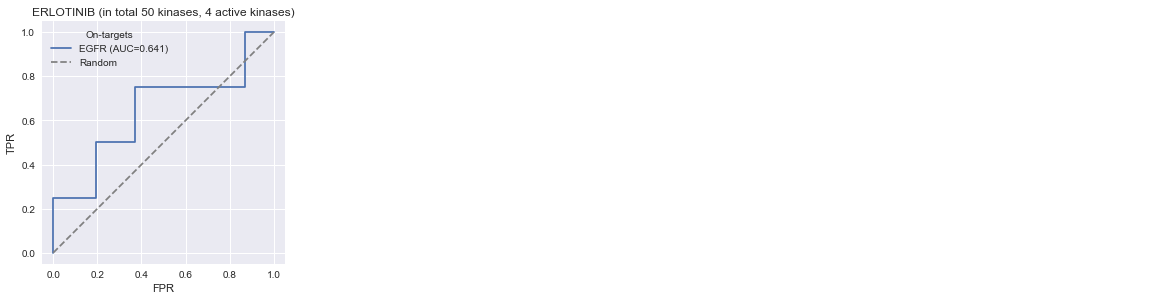

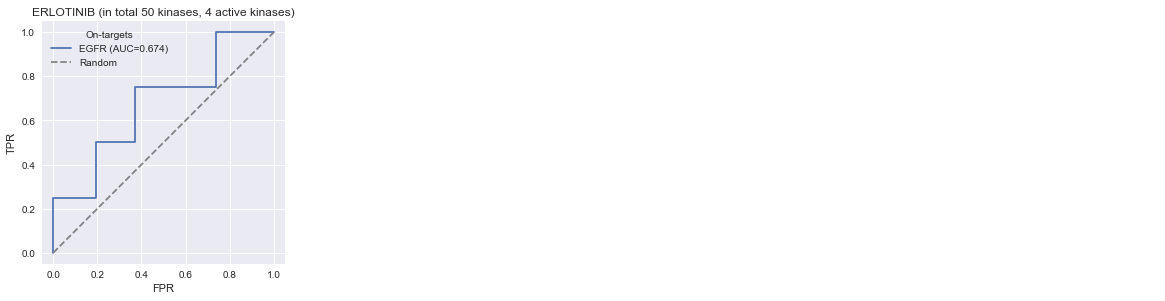

In [14]:
ligand_kinase_pairs = [["Erlotinib", "EGFR"]]
ligand_expo_id = None
all_vs_subset_fingerprint_performance(ligand_kinase_pairs, ligand_expo_id)

### Erlotinib

All residues: AUC mean 0.6413043478260869, std 0.0
Number of IFPs for IRE: 12
(residue position, number of features across all IFPs)
[(3, 12), (4, 5), (11, 12), (15, 12), (16, 4), (17, 12), (24, 5), (28, 5), (43, 12), (44, 1), (45, 12), (46, 10), (47, 12), (48, 24), (49, 12), (51, 12), (52, 6), (55, 12), (77, 12), (80, 10), (81, 8)]
Residues interacting with IRE:
3 4 11 15 16 17 24 28 43 44 45 46 47 48 49 51 52 55 77 80 81
Subset residues: AUC mean 0.7880434782608695, std 0.0


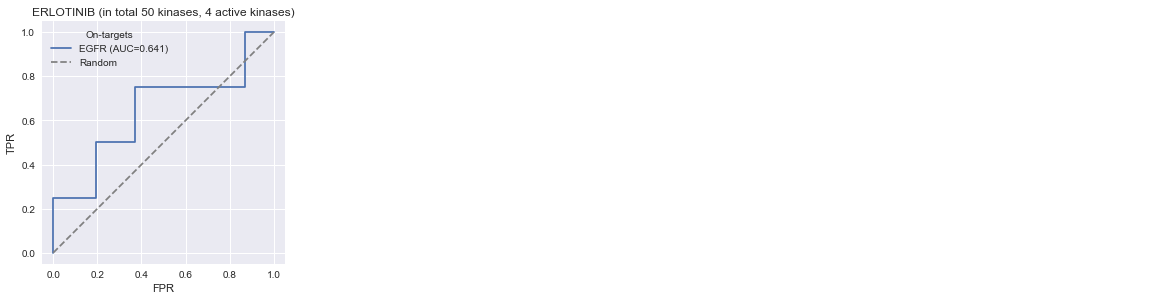

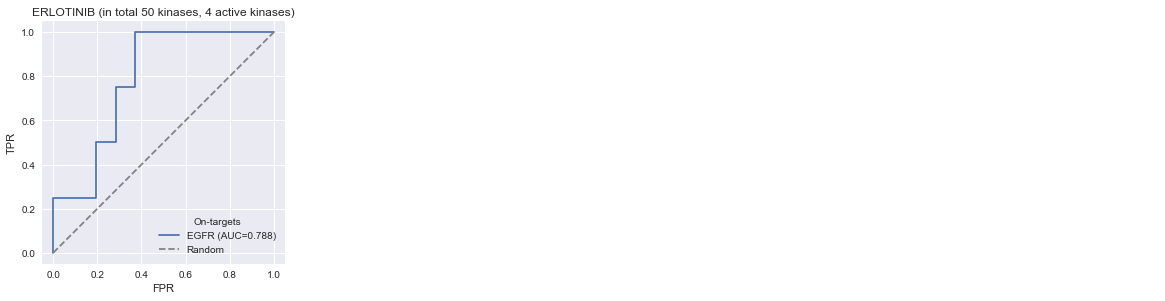

In [10]:
ligand_kinase_pairs = [["Erlotinib", "EGFR"]]
ligand_expo_id = "IRE"
all_vs_subset_fingerprint_performance(ligand_kinase_pairs, ligand_expo_id)

### Imatinib

All residues: AUC mean 0.9538461538461539, std 0.033234567684142895
Number of IFPs for STI: 57
(residue position, number of features across all IFPs)
[(3, 56), (4, 2), (8, 88), (11, 57), (15, 57), (16, 55), (17, 55), (24, 106), (27, 55), (28, 55), (31, 52), (35, 3), (36, 57), (43, 55), (45, 112), (46, 2), (47, 110), (48, 115), (49, 2), (50, 2), (51, 53), (52, 2), (61, 2), (66, 53), (67, 104), (68, 70), (69, 54), (77, 55), (80, 57), (81, 110), (82, 110)]
Residues interacting with STI:
3 4 8 11 15 16 17 24 27 28 31 35 36 43 45 46 47 48 49 50 51 52 61 66 67 68 69 77 80 81 82
Subset residues: AUC mean 0.9384615384615383, std 0.012561485860426555


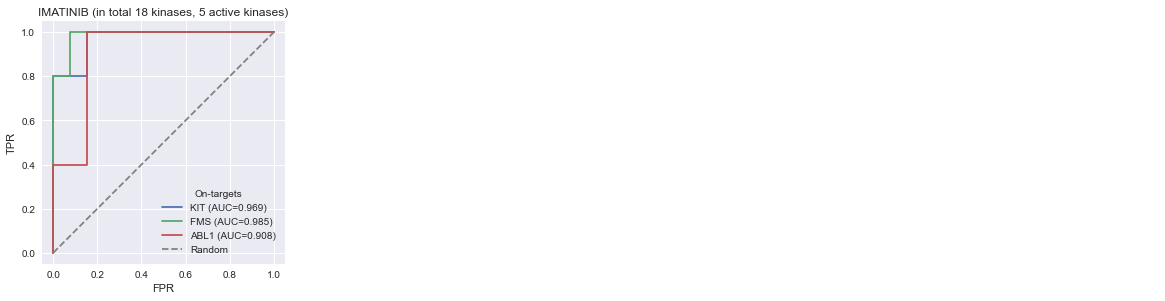

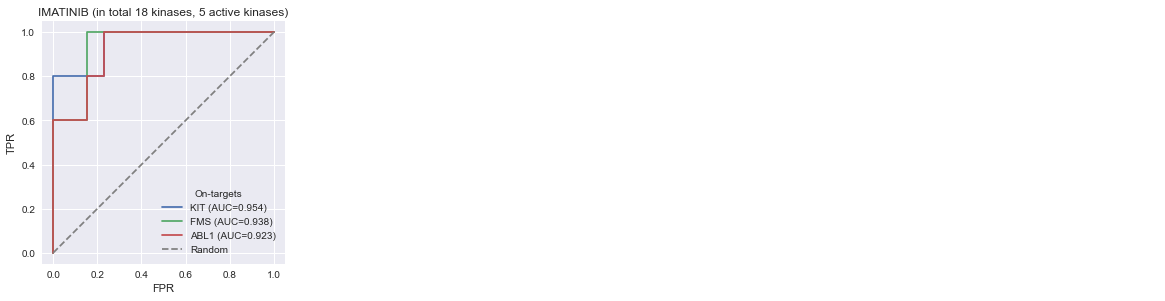

In [11]:
ligand_kinase_pairs = [["Imatinib", "KIT"], ["Imatinib", "FMS"], ["Imatinib", "ABL1"]]
ligand_expo_id = "STI"
all_vs_subset_fingerprint_performance(ligand_kinase_pairs, ligand_expo_id)

### Bosutinib

All residues: AUC mean 0.7867474747474746, std 0.05293601622808995
Number of IFPs for DB8: 26
(residue position, number of features across all IFPs)
[(1, 1), (3, 26), (4, 11), (11, 26), (15, 26), (16, 24), (17, 26), (24, 13), (28, 10), (36, 23), (43, 21), (44, 9), (45, 27), (46, 16), (47, 43), (48, 51), (49, 24), (50, 19), (51, 23), (55, 2), (59, 4), (75, 5), (77, 29), (80, 23), (81, 22), (82, 7), (84, 5)]
Residues interacting with DB8:
1 3 4 11 15 16 17 24 28 36 43 44 45 46 47 48 49 50 51 55 59 75 77 80 81 82 84
Subset residues: AUC mean 0.8345858585858587, std 0.033771204232039324


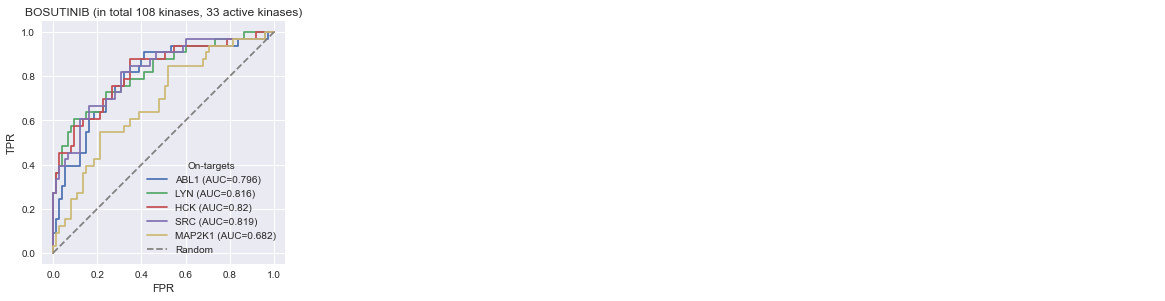

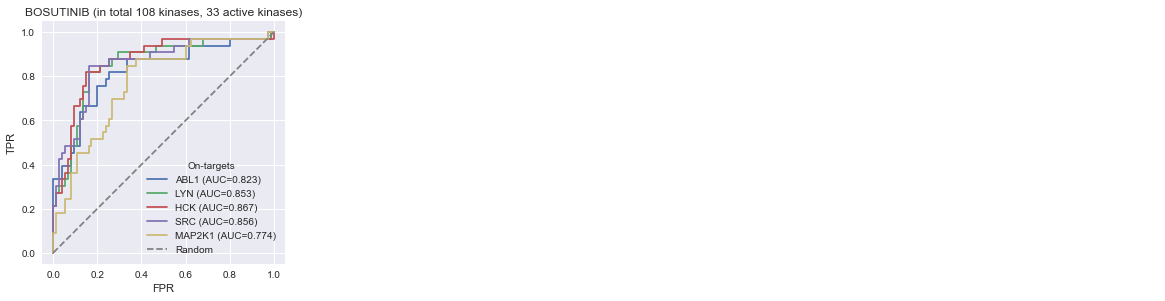

In [12]:
ligand_kinase_pairs = [
    ["Bosutinib", "ABL1"],
    ["Bosutinib", "LYN"],
    ["Bosutinib", "HCK"],
    ["Bosutinib", "SRC"],
    ["Bosutinib", "MAP2K1"],
]
ligand_expo_id = "DB8"
all_vs_subset_fingerprint_performance(ligand_kinase_pairs, ligand_expo_id)

### Doramapimod

All residues: AUC mean 0.8428571428571429, std 0.0
Number of IFPs for B96: 13
(residue position, number of features across all IFPs)
[(3, 5), (8, 4), (11, 13), (15, 13), (16, 6), (17, 13), (20, 8), (23, 5), (24, 26), (27, 13), (28, 13), (31, 9), (35, 10), (36, 13), (38, 2), (43, 12), (44, 2), (45, 13), (46, 6), (47, 13), (48, 22), (49, 2), (51, 2), (52, 1), (61, 12), (66, 8), (68, 13), (77, 12), (79, 12), (80, 13), (81, 26), (82, 24), (84, 2), (85, 2)]
Residues interacting with B96:
3 8 11 15 16 17 20 23 24 27 28 31 35 36 38 43 44 45 46 47 48 49 51 52 61 66 68 77 79 80 81 82 84 85
Subset residues: AUC mean 0.7821428571428571, std 0.0


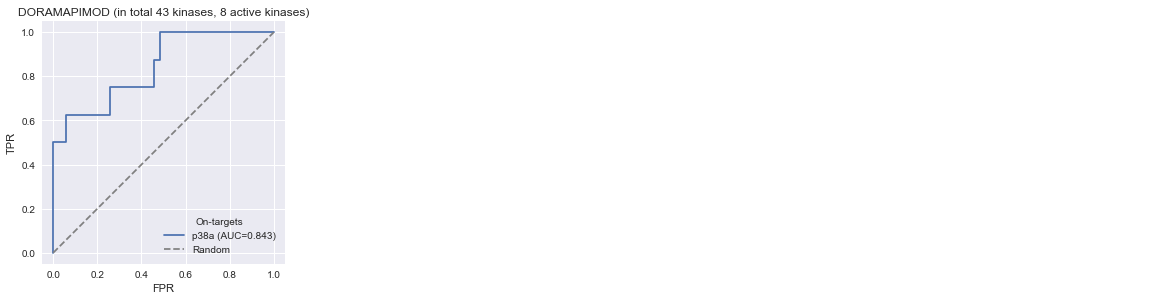

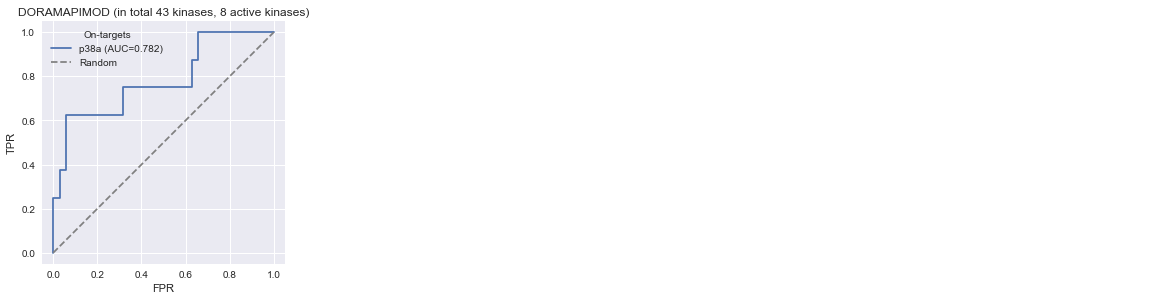

In [13]:
ligand_kinase_pairs = [["Doramapimod", "p38a"]]
ligand_expo_id = "B96"
all_vs_subset_fingerprint_performance(ligand_kinase_pairs, ligand_expo_id)

## Compare subset KiSSim fingerprints (with `kissim.comparison`)

## Performance all vs. subset fingerprints (with `kissim.comparison`)